<a href="https://colab.research.google.com/github/mohdrahil7/image-Segmentation/blob/master/Unet_arc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
#implementation of fcn-8 code
from keras.layers import *
from keras import Model
from matplotlib import pyplot as plt
import cv2
import os
import numpy as np

In [0]:
os.chdir('/content/drive')

In [0]:
os.chdir('My Drive')

In [0]:
os.chdir('dataset')

In [0]:
#reading the training data 
#reading x and y data
x=np.load('Skin_TestX.npy')
y=np.load('Skin_TestY.npy')
#reading the test_data
x_test=np.load('Skin_ValidX.npy')
y_test=np.load('Skin_ValidY.npy')

In [24]:
print(x.shape)
print(y.shape)
print(x_test.shape)
print(y_test.shape)

(600, 192, 256, 3)
(600, 192, 256)
(150, 192, 256, 3)
(150, 192, 256)


In [25]:
#preprocessing of data
#converting the data into first gray scale and then reducing dimensions
x_gray=[]
for i in range(0,len(x)):
    x_gray.append(cv2.cvtColor(x[i],cv2.COLOR_BGR2GRAY))
x=np.array(x_gray)
x_test_gray=[]
for i in range(0,len(x_test)):
    x_test_gray.append(cv2.cvtColor(x_test[i],cv2.COLOR_BGR2GRAY))
x_test=np.array(x_test_gray)

del x_gray
del x_test_gray

#resizing of the array into size of 128, 128 using cv2
x_resize=[]
for i in range(0,len(x)):
    x_resize.append(cv2.resize(x[i],(128,128)))
print(len(x_resize))
x_tresize=[]
for i in range(0,len(x_test)):
    x_tresize.append(cv2.resize(x_test[i],(128,128)))
print(len(x_tresize))

x=np.array(x_resize)
print(x.shape)
x_test=np.array(x_tresize)
print(x_test.shape)

#now converting each element into 3 dimension
x=x.reshape(-1,128,128,1)
print(x.shape)
x_test=x_test.reshape(-1,128,128,1)
print(x_test.shape)

600
150
(600, 128, 128)
(150, 128, 128)
(600, 128, 128, 1)
(150, 128, 128, 1)


In [26]:
#now performing the same operations for the y data
y_resize=[]
y_tresize=[]
for i in range(0,len(y)):
    y_resize.append(cv2.resize(y[i],(128,128)))
len(y_resize)
y=np.array(y_resize)
print(y.shape)
y=y.reshape(-1,128,128,1)
print(y.shape)

for i in range(0,len(y_test)):
    y_tresize.append(cv2.resize(y_test[i],(128,128)))
len(y_tresize)
y_test=np.array(y_tresize)
print(y_test.shape)
y_test=y_test.reshape(-1,128,128,1)
print(y_test.shape)

del y_resize
del y_tresize
del x_resize
del x_tresize

(600, 128, 128)
(600, 128, 128, 1)
(150, 128, 128)
(150, 128, 128, 1)


In [27]:
#finally after performing the all transformation
print(x.shape)
print(y.shape)
print(x_test.shape)
print(y_test.shape)

(600, 128, 128, 1)
(600, 128, 128, 1)
(150, 128, 128, 1)
(150, 128, 128, 1)


In [0]:
#performing the normalization of taking each value between 0 and 1
x=x.astype('float32')/255
y=y.astype('float32')/255
x_test=x_test.astype('float32')/255
y_test=y_test.astype('float32')/255

In [0]:
#normalizing the training data
x_mean=np.mean(x)
x_std=np.std(x)
x=x-x_mean
x=x/x_std

In [0]:
#normalizing test data
x_test=x_test-x_mean
x_test=x_test/x_std

In [38]:
#creating a Unet Network but since we are not creating the sequentail network so we need model API to create model

def create_model():
  input_img=Input(shape=(128,128,1))
  
  #block_1
  z=Conv2D(32,(3,3),padding='same',input_shape=(128,128,1),activation='relu',name='block1_conv1')(input_img)
  conv1=Conv2D(32,(3,3),padding='same',activation='relu',name='block1_conv2')(z)
  z=MaxPool2D(pool_size=(2,2),strides=(2,2),name='block1_maxpooling')(conv1)

  #block_2
  z=Conv2D(64,(3,3),padding='same',activation='relu',name='block2_conv1')(z)
  conv2=Conv2D(64,(3,3),padding='same',activation='relu',name='block2_conv2')(z)
  z=MaxPool2D(pool_size=(2,2),strides=(2,2),name='block2_maxpooling')(conv2)

  #block_3
  z=Conv2D(128,(3,3),padding='same',activation='relu',name='block3_conv1')(z)
  z=Conv2D(128,(3,3),padding='same',activation='relu',name='block3_conv2')(z)
  up1=Conv2DTranspose(128,(2,2),strides=(2,2),activation='relu',padding='same',name='upsampling')(z)

  concat1=concatenate([up1,conv2])
  #block_4
  z=Conv2D(64,(3,3),padding='same',activation='relu',name='block4_conv1')(concat1)
  z=Conv2D(64,(3,3),padding='same',activation='relu',name='block4_conv2')(z)
  up2=Conv2DTranspose(64,(2,2),strides=(2,2),activation='relu',padding='same',name='upsampling2')(z)
  
  concat2=concatenate([up2,conv1])
  #block_5
  z=Conv2D(32,(3,3),padding='same',activation='relu',name='block5_conv1')(concat2)
  z=Conv2D(32,(3,3),padding='same',activation='relu',name='block5_conv2')(z)
  z=Dropout(0.5)(z)
  final=Conv2D(1,(1,1),activation='relu',padding='same' ,name='final')(z)

  model1=Model(input_img,final)
  return model1

model=create_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 32) 320         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 32) 9248        block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_maxpooling (MaxPooling2D (None, 64, 64, 32)   0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [0]:
os.chdir('/content/drive/My Drive')

In [0]:
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [0]:
#creating callbacks
#creating the callbacks and checkpoints to save best model
from keras.callbacks import EarlyStopping,ModelCheckpoint
es=EarlyStopping(monitor="val_loss",mode='min',patience=10 ,verbose=1)
cp=ModelCheckpoint('best_model_FCNN8.h5',monitor="val_loss",mode='min',verbose=1,save_best_only='true')

In [42]:
history=model.fit(x,y,verbose=1,batch_size=32,epochs=100,callbacks=([es,cp]),validation_split=(0.2),shuffle='true',class_weight='auto')

Train on 480 samples, validate on 120 samples
Epoch 1/100
480/480 [==============================] - 9s 18ms/step - loss: 0.1647 - accuracy: 0.7795 - val_loss: 0.1364 - val_accuracy: 0.8331

Epoch 00001: val_loss improved from inf to 0.13638, saving model to best_model_FCNN8.h5
Epoch 2/100
480/480 [==============================] - 1s 3ms/step - loss: 0.1394 - accuracy: 0.8026 - val_loss: 0.1540 - val_accuracy: 0.8153

Epoch 00002: val_loss did not improve from 0.13638
Epoch 3/100
480/480 [==============================] - 1s 3ms/step - loss: 0.1346 - accuracy: 0.8053 - val_loss: 0.1521 - val_accuracy: 0.8114

Epoch 00003: val_loss did not improve from 0.13638
Epoch 4/100
480/480 [==============================] - 1s 3ms/step - loss: 0.1301 - accuracy: 0.8153 - val_loss: 0.1439 - val_accuracy: 0.8244

Epoch 00004: val_loss did not improve from 0.13638
Epoch 5/100
480/480 [==============================] - 1s 3ms/step - loss: 0.1238 - accuracy: 0.8244 - val_loss: 0.1462 - val_accuracy: 

In [43]:
#evaluation of unet
result=model.evaluate(x_test,y_test)
print(result)

150/150 [==============================] - 0s 2ms/step
[0.06427322303255399, 0.91311115026474]


In [0]:
#plotting the accuracy and loss graph
train_loss=history.history['loss']
train_acc=history.history['accuracy']
val_loss=history.history['val_loss']
val_acc=history.history['val_accuracy']
epoch=range(len(train_loss))

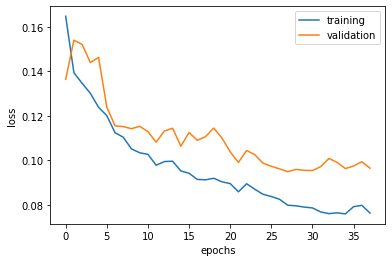

In [53]:
#plotting the garph of loss
plt.plot(epoch,train_loss)
plt.plot(epoch,val_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training','validation'])

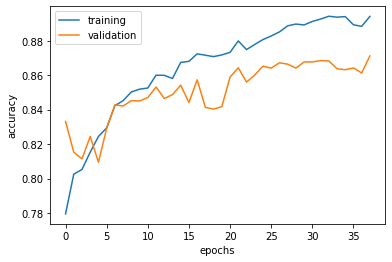

In [54]:
#graph for accuracy
plt.plot(epoch,train_acc)
plt.plot(epoch,val_acc)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['training','validation'])

In [0]:
#predictions
predict=model.predict(x_test[100].reshape(1,128,128,1))
predict=predict >0.5

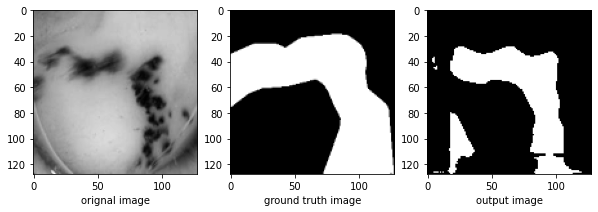

In [59]:
#visualization of results
plt.figure(figsize=(10,10))
plt.subplot(131).imshow(x_test[100].reshape(128,128),'gray')
plt.xlabel('orignal image')
plt.subplot(132).imshow(y_test[100].reshape(128,128),'gray')
plt.xlabel('ground truth image')
plt.subplot(133).imshow(predict.reshape(128,128),'gray')
plt.xlabel('output image')
plt.show()